In [6]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import tensorflow as tf
import math
import time
from module.lib.layers import *
import module.lib.functions as func
from module.lib import optical_chart
import matplotlib_style
import pandas as pd
import cv2
import glob
import re
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["font.size"]=18

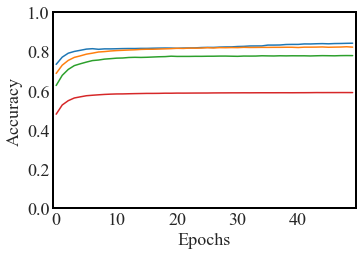

In [16]:
matplotlib_style.paper()

result = pd.read_excel("/Users/takumi/Dropbox/OEXP_ishibashi_revised/APEX_MO-D2NN/論文用データ/評価結果データ/5layer/回転角.xlsx", sheet_name=3)
idx = [1,4,5,7]
idx.reverse()

for i in idx:
    plt.plot(result.values[:, i])

plt.ylim(0,1)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig("images/faraday_lr_constant.png")

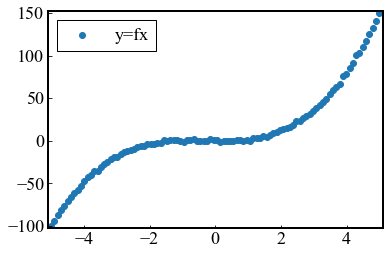

In [32]:
x = np.linspace(-5, 5, 100)
y = np.random.randn(100) + x**2 + x**3
plt.scatter(x, y, label="y=fx")
plt.legend()

In [78]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

In [155]:
model_path = '/Users/takumi/Documents/研究/D2NN/model/Proposal MOD2NN/trained_data/with analyzer/20220424_7'
model = tf.keras.models.load_model(model_path)
#model.summary()
#model.get_config()

In [156]:
pattern = r'cx_mo'
mo_layers = []
save = False
each_save = False
for layer in model.layers:
    result = re.match(pattern, layer.name)
    if result:
        mo_layers.append(layer)

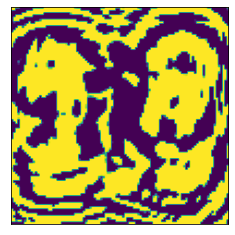

In [157]:
from matplotlib.colors import LinearSegmentedColormap
cmap12 = LinearSegmentedColormap.from_list('custom', ["#d8d4e5", "#eebbc3"])

for i in range(len(mo_layers)):
    w = mo_layers[i].get_weights()[0]
    w = np.sin(w)
    #w = np.where(w>0,1,0)
    plt.imshow(w, cmap="viridis", interpolation=None)
    plt.xticks([],[])
    plt.yticks([],[])
    plt.savefig("images/faraday_l"+str(i)+".png", dpi=300)

AttributeError: __enter__

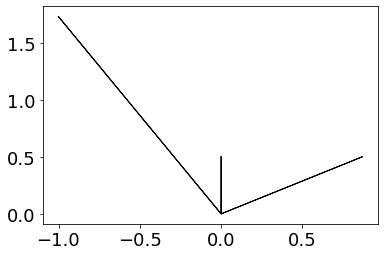

In [21]:
r1 = 1.0
r2 = 2.0
r3 = -0.5
theta1 = r1*np.pi/6
theta2 = r2*np.pi/3
theta3 = r3*np.pi

a1 = r1 * tf.exp(1.0j*theta1)
a2 = r2*tf.exp(1.0j*theta2)
a3 = r3*tf.exp(1.0j*theta3)
plt.arrow(0,0,tf.math.real(a1),tf.math.imag(a1))
plt.arrow(0,0,tf.math.real(a2),tf.math.imag(a2))
plt.arrow(0,0,tf.math.real(a3),tf.math.imag(a3))



with tf.GradientTape as tape:
    tape.watch(a1)
    a = tf.abs(a1+a2+a3)

plt.arrow(0,0, tf.math.real(a), tf.math.imag(a), color="red")

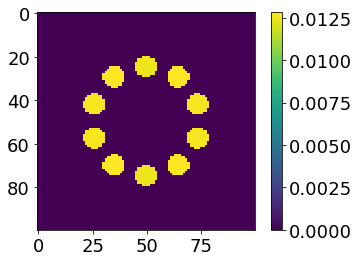

In [12]:
filters = CircleOnCircumferenceDetector.make_filters((100, 100), 25, 5, 10)
ones = np.ones((100, 100))
y = ones * filters[9,:,:]
plt.imshow(np.sum(filters, axis=0), interpolation="none")
plt.colorbar()

In [17]:
import matplotlib_style
import matplotlib.animation as animation
from scipy import stats
matplotlib_style.paper()

In [27]:
wavelength = 633e-9
d = 1.0e-6
theta = np.pi/20
p = np.linspace(0, 1, 100, endpoint=True)
theta_points = []
theta_images = []
chart_list = []

In [28]:
for _p in p:
    np.random.seed(1)
    X = stats.bernoulli.rvs(p=_p, size=(100, 100))
    Er = np.exp(-1.j)
    El = np.exp(-1.j)
    chart = (2*optical_chart.char1((100,100))-1) * X
    chart_list.append(chart)
    Er = Er * np.exp(-1.j*chart*theta)
    El = El * np.exp(1.j*chart*theta)

    Er = func.angular_spectrum(Er, wavelength, 0.5e-3, d)
    El = func.angular_spectrum(El, wavelength, 0.5e-3, d)

    theta_img = (np.log(El).imag - np.log(Er).imag)/2
    theta_points.append(theta_img[50, 50])
    theta_images.append(theta_img)

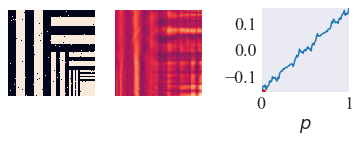

In [8]:
vmax = np.max(theta_images)
vmin = np.min(theta_images)
fig, axes = plt.subplots(1,3)
axes[0].imshow((2*optical_chart.char1((100,100))-1))
axes[0].set_xticks([],[])
axes[0].set_yticks([],[])

axes[1].set_xticks([],[])
axes[1].set_yticks([],[])

axes[2].plot(p, theta_points)
#axes[2].set_aspect("equal", 'datalim')
#axes[2].set_ylabel("Angle of polarization plane")
axes[2].set_xlabel(r"$p$")

#fig.tight_layout()
sc = axes[2].scatter(0,0, color="red")
def update(num):
    axes[0].imshow(chart_list[-num])
    axes[0].set_title(r'$p={:.2f}$'.format(p[-num]))
    axes[1].imshow(theta_images[-num], vmax=vmax, vmin=vmin)
    offset = sc.get_offsets()
    offset.data[0, 0] = p[-num]
    offset.data[0, 1] = theta_points[-num]
    axes[2].set_xlim(0, 1)


l, b, w, h = axes[1].get_position().bounds
ll, bb, ww, hh = axes[2].get_position().bounds
axes[2].set_position([l + 0.34, 0.4, w, 0.3])

ani = animation.FuncAnimation(fig, update, len(p), interval=40, blit=False)
ani.save("gif/writing_error2.gif", dpi=100)
#plt.imshow(X)

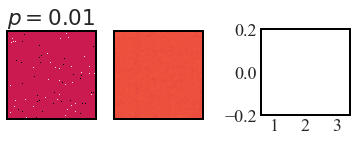

In [29]:
vmax = np.max(theta_images)
vmin = np.min(theta_images)
fig, axes = plt.subplots(1,3)
axes[0].imshow((2*optical_chart.char1((100,100))-1))
axes[0].set_xticks([],[])
axes[0].set_yticks([],[])

axes[1].set_xticks([],[])
axes[1].set_yticks([],[])

#axes[2].set_aspect("equal", 'datalim')
#axes[2].set_ylabel("Angle of polarization plane")
#fig.tight_layout()
rects = axes[2].bar([1,2,3],theta_images[-1][25::25,50], color="red")
def update(num):
    axes[0].imshow(chart_list[-num])
    axes[0].set_title(r'$p={:.2f}$'.format(p[-num]))
    axes[1].imshow(theta_images[-num], vmax=vmax, vmin=vmin)
    for i, rect in enumerate(rects):
        hists = theta_images[-num][25::25, 50]
        axes[2].clear()
        axes[2].set_ylim(-0.2, 0.2)
        axes[2].bar([1,2,3], hists)
        #rect.set_height(hists[i])


l, b, w, h = axes[1].get_position().bounds
ll, bb, ww, hh = axes[2].get_position().bounds
axes[2].set_position([l + 0.34, 0.4, w, 0.3])

ani = animation.FuncAnimation(fig, update, len(p), interval=40, blit=False)
ani.save("gif/writing_error3.gif", dpi=200)
#plt.imshow(X)

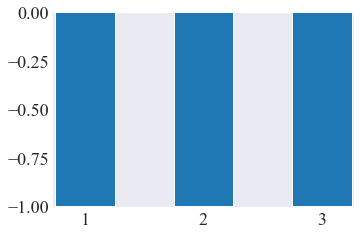

In [45]:
hists = np.array(theta_images)[:, 25::25, 50]
x = [1, 2, 3]
rects = plt.bar(x, [-1,-1,-1], 0.5)